# Setup

In [1]:
# Imports
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import shutil

import utils

from classes import Tetraloop, Chain, Fragment
from collections import Counter, OrderedDict
from pathlib import Path
from pprint import pprint
from PyPDF2 import PdfWriter

In [2]:
# matplotlib config

mpl.rcParams['figure.figsize'] = [8, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
# Paths
clusters_dir = Path('../../all_clusters/')
structures_dir = Path('../../all_structures/')
data_dir = Path('data/')
fragments_dir = Path('data/fragments/')
figures_dir = Path('figures/')

# Create figures directory if none exists
if not figures_dir.exists():
    figures_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Load all data
tloops_raw = utils.load(data_dir/'tloops_raw.pickle')
tloops_filtered = utils.load(data_dir/'tloops_filtered.pickle')

chains_annotated_raw = utils.load(data_dir/'chains_annotated_raw.pickle')
chains_annotated_filtered = utils.load(data_dir/'chains_annotated_filtered.pickle')

fragments_8_raw = utils.load(fragments_dir/'fragments_8_raw.pickle')
fragments_8_filtered = utils.load(fragments_dir/'fragments_8_filtered.pickle')
fragments_10_filtered = utils.load(fragments_dir/'fragments_10_filtered.pickle')
fragments_12_filtered = utils.load(fragments_dir/'fragments_12_filtered.pickle')
fragments_14_filtered = utils.load(fragments_dir/'fragments_14_filtered.pickle')

In [5]:
# Load metadata
metadata = pd.read_csv(data_dir/'RCSB_metadata.csv', header=[1]).dropna(axis=1, how='all')

In [8]:
# Other functions

def get_res_array(sequences:list[str], res_names:list[str]=['A','U','C','G']):
    res_array= np.zeros(shape=(len(res_names), len(sequences[0])))
    for seq in sequences:
        for pos, res in enumerate(seq):
            res_array[res_names.index(res)][pos] += 1
    res_array = res_array/res_array.sum(axis=0, keepdims=True)
    return res_array


def merge_pdfs_in_dir(dir:Path, filename:str='merged_pdf'):
    merger = PdfWriter()
    for item in dir.iterdir():
        merger.append(item)
    merger.write(dir.parent/(filename + '.pdf'))
    merger.close()
    shutil.rmtree(dir)


def format_filename(text:str):
    return text.lower().replace(' ','_')

In [23]:
# Plot functions

# Plot bar graph
def plot_bar(data:dict, title:str='bar', xlabel:str='', ylabel:str='', dir:Path=figures_dir, save = True, save_as_pdf = True, **kwargs) -> None:
    ax = plt.subplots(figsize=(len(data)*0.3,3))[1]
    bar_plot = ax.bar(range(len(data)), data.values(), align='edge', width=0.5, **kwargs)
    ax.bar_label(bar_plot, rotation='vertical', padding=5)
    ax.set_xticks(range(len(data)), data.keys(), rotation='vertical', horizontalalignment='left')
    ax.set_title(title, y=1.1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
        
    # Cosmetic adjustments
    ax.margins(x=0.5/len(data), tight=True)
    ax.spines[['right', 'top']].set_visible(False)
    
    if save:
        if save_as_pdf: save_pdf(dir/format_filename(title))
        else: plt.savefig(dir/format_filename(title))

    plt.show()


# Plot stacked bar graph
def plot_stacked_bar(x, array, labels:list[str], title:str='stacked_bar', xlabel:str='', ylabel:str='', dir:Path=figures_dir, save = True, save_as_pdf = True, **kwargs) -> None:
    ax = plt.subplots(figsize=(len(x)*0.3,3))[1]
    ax.bar(x, array[0], label=labels[0])
    for i in range(1, len(array)):
        ax.bar(x, array[i], bottom=np.sum(array[:i], axis=0), label=labels[i], **kwargs)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right', bbox_to_anchor=(1.5,1.03))
    
    if save:
        if save_as_pdf: save_pdf(dir/format_filename(title))
        else: plt.savefig(dir/format_filename(title))
    
    plt.show()


def save_pdf(path:Path):
    plt.savefig(Path(path.with_suffix('.pdf')), bbox_inches='tight')
    plt.close()

In [10]:
def get_pdb_ids(data, unique=False, clusters=None):
    if clusters: pdb_ids = [i.pdb_id for i in data if i.clust_id in clusters]
    else: pdb_ids = [i.pdb_id for i in data]
    if unique: return set(pdb_ids)
    else: return pdb_ids


def get_seqs(data, unique=False, clusters=None):
    if clusters: seqs = [i.res_seq for i in data if i.clust_id in clusters]
    else: seqs = [i.res_seq for i in data]
    if unique: return set(seqs)
    else: return seqs


def get_counter_dict(data):
    return OrderedDict(Counter(data).most_common())

In [24]:
def stats(data, label:str ='', seqs_hist:bool=False, clust_seqs_hist:bool=False, clust_hist:bool=False, res_pos_hist:bool=False) -> None:
    
    seqs = [i.res_seq for i in data] # Sequences
    pdb_ids = [i.pdb_id for i in data] # PDB IDs
    
    print(
        f'{label}:\n'
        f'- Amount: {len(data)}\n'
        f'- Unique sequences: {len(set(seqs))}\n'
        f'- PDB IDs: {len(set(pdb_ids))}'
    )
    if isinstance(data[0], Fragment) or isinstance(data[0], Chain):
        seq_ids = [i.seq_id for i in data] # Sequence IDs (PDB ID + chain ID)
        print(f'- Chains: {len(set(seq_ids))}')
    
    # Residue position histogram
    if res_pos_hist:
        res_array = get_res_array(seqs, ['A','U','C','G','N','I'])
        plot_stacked_bar(range(len(seqs[0])), res_array, ['A','U','C','G','N','I'], f'{label} residue position frequencies', save_as_pdf=False)
    
    # Sequence histogram
    if seqs_hist:
        seqs_dict = OrderedDict(Counter(seqs).most_common())
        plot_bar(seqs_dict, f'{label} sequence frequencies')
    
    # Sequence by cluster
    if clust_seqs_hist:
        tmp_dir = figures_dir/'tmp'#Path(f'{figures_dir}/tmp')
        if tmp_dir.exists() and tmp_dir.is_dir():
            shutil.rmtree(tmp_dir)
        tmp_dir.mkdir(parents=True, exist_ok=True)
    
        clust_ids = set([i.clust_id for i in data])
        for c in clust_ids:
            clust_seqs = [t.res_seq for t in data if t.clust_id == c]
            clust_seqs_dict = OrderedDict(Counter(clust_seqs).most_common())
            plot_bar(clust_seqs_dict, f'{label} cluster {c} sequence frequencies', dir=tmp_dir)
        merge_pdfs_in_dir(tmp_dir, format_filename(f'{label} cluster sequence frequencies.pdf'))
    
    # Cluster histogram
    if clust_hist:
        clust_ids = [t.clust_id for t in data]
        clust_ids_dict = OrderedDict(sorted(Counter(clust_ids).items()))
        plot_bar(clust_ids_dict, f'{label} cluster frequencies')

    print(f'Figures saved to /{figures_dir}\n')

## PDB ID (metadata)

In [53]:
# # PDB ID query string for RCSB
# print(", ".join(set([i.pdb_id for i in tloops_raw])))

1j5e, 1e4p, 1yij, 2p89, 379d, 4u53, 2koc, 5dm6, 2ku0, 2zzm, 4qk9, 3w3s, 1hs3, 1zdh, 2uub, 1un6, 1zig, 2aht, 4gkk, 4v7x, 3d0x, 4zt9, 4v5a, 1hnw, 4v9o, 4v9k, 4wt8, 2uu9, 3lqx, 5mdz, 1dk1, 1k4a, 4v5k, 2pxb, 3g6e, 3zjv, 1nyb, 5doy, 1y39, 4v7w, 3skr, 1fyo, 1txs, 1zdi, 4wfm, 2ktz, 2tob, 4v7y, 1rlg, 4u1u, 2mqv, 3ndb, 1nwy, 2lhp, 5fkh, 5ibb, 2qex, 4w2h, 3j9m, 1ffk, 1kuq, 2euy, 2nc1, 4w2i, 2bny, 3e5f, 3ccu, 4y1j, 2n3r, 4b3t, 2v3c, 1q29, 4wqr, 5msf, 3skz, 2hua, 1i94, 2o44, 3rw6, 2n3q, 4v6a, 4v9p, 5fdu, 5fj1, 4e8p, 4c7o, 5j4d, 2lup, 1vqn, 1ldz, 4pqv, 4nxh, 5f98, 2oiu, 1r7z, 1yi2, 4b5r, 1vqm, 1rfr, 4oqu, 2i7e, 1xnq, 4u27, 3u4m, 4v8x, 4dv6, 4ji7, 4w4g, 5fk6, 3skw, 5jc9, 1hr2, 4k27, 4w92, 4k50, 4wsd, 5f8k, 1yjn, 2jyf, 4l47, 3rg5, 4wpo, 4v83, 4v9f, 3jct, 5dat, 5mrc, 3umy, 4v6c, 4ypb, 4wra, 5b2o, 1njp, 4dr3, 4lvx, 4p9r, 3iqp, 2jwv, 4v99, 2jxv, 2e5l, 4u3u, 4v6g, 2pxk, 5an9, 5dm7, 4un5, 4v8d, 1kqs, 4u55, 2uxc, 5ib8, 28sp, 5j02, 5j7l, 1q93, 3slm, 4v8c, 3adc, 4v7s, 5t62, 1n66, 5j4b, 5b2q, 2pxq, 1m90, 1s9s

In [42]:
# SKIP
# def get_metadata(pdb_id:str):
#     metadata = {"organisms": []}

#     # def get_entity_details(line:str):
#     #     data = line.split()
#     #     if len(data) > 1 and data[1] not in ["non-polymer", "water"]:
#     #         nonlocal lines
#     #         lines += [line.strip()]
    
#     def get_organism(line: str):
#         # nonlocal metadata
#         metadata["organisms"] += [line.split("'")[1]]

#     with open((structures_dir/pdb_id).with_suffix('.cif'), 'r') as file:
#         callable = lambda *args: None
#         for line in file:

#             # Decription
#             if "_struct_keywords.pdbx_keywords" in line:
#                 metadata["classification"] = line.split(" ", 1)[1].strip().strip("'")
            
#             # Organism
#             elif (  "_pdbx_entity_src_syn.organism_scientific" in line
#                     or "_em_entity_assembly_naturalsource.organism" in line
#                     or "_entity_src_gen.pdbx_gene_src_scientific_name" in line):
#                 metadata["organisms"] += [line.split(" ", 1)[1].strip().strip("'")]
            
#             elif "_entity_src_nat.details" in line: 
#                 callable = get_organism
#                 continue
            
#             elif "#" in line:
#                 callable = lambda *args: None
            
#             # case '_entity.details': callable = get_entity_details; continue
#             # # _entity.details

#             callable(line)
#     metadata["organisms"] = set(filter(None, metadata["organisms"]))
#     return metadata

# for pdb_id in [i.pdb_id for i in chains_annotated_filtered][:20]:
#     print(f"{pdb_id:5}{get_metadata(pdb_id)}")

In [12]:
# SKIP
# Retrieve structure and organism info as CSV

# def get_rcsb_info(pdb_id: str):
#     entry_url = f"https://data.rcsb.org/rest/v1/core/entry/{pdb_id}"
#     entry_response = requests.get(entry_url)
#     if entry_response.status_code == 200:
#         entry_info = {"entities": {}}
#         entry_data = entry_response.json()
#         entry_info["classification"] = entry_data['struct_keywords']['pdbx_keywords']
#         entity_ids = entry_data["rcsb_entry_container_identifiers"]["entity_ids"]
#         for entity_id in entity_ids:
#             entity_url = f"https://data.rcsb.org/rest/v1/core/polymer_entity/{pdb_id}/{entity_id}"
#             entity_response = requests.get(entity_url)
#             if entity_response.status_code == 200:
#                 entity_info = {}
#                 entity_data = entity_response.json()
#                 entity_info["type"] = entity_data["entity_poly"]["type"]
#                 if "organism" not in entry_info and "rcsb_entity_source_organism" in entity_data and "scientific_name" in entity_data["rcsb_entity_source_organism"][0]: # TODO what is this key doesn't exist?
#                     entry_info["organism"] = entity_data["rcsb_entity_source_organism"][0]["scientific_name"]
#                 entity_info["description"] = entity_data["rcsb_polymer_entity"]["pdbx_description"]
#                 entry_info["entities"][entity_id] = entity_info
#     return entry_info

# pprint(get_rcsb_info('1dk1'))

In [12]:
def get_structure(pdb_id: str):
    matching_rows = metadata[metadata['Entry ID'] == pdb_id.upper()]
    if not matching_rows.empty:
        return matching_rows.iloc[0]["Stucture Keywords"]
    else:
        return ""


def get_organisms(pdb_id: str):
    organisms = []
    start_loc = metadata.index[metadata['Entry ID'] == pdb_id.upper()]
    if not start_loc.any(): return set(["N/A"])
    start_idx = start_loc.tolist()[0]
    for index, row in metadata.iloc[start_idx:].iterrows():
        if row['Entry ID'] == pdb_id.upper() or pd.isna(row['Entry ID']):
            organisms += [str(row["Source Organism"])]
        else: break
    return set([i for i in organisms if i != "nan"])

In [ ]:
tloops_raw_structures = [get_structure(i).lower() for i in get_pdb_ids(tloops_raw)]
tloops_filtered_structures = [get_structure(i).lower() for i in get_pdb_ids(tloops_filtered)]
chains_raw_structures = [get_structure(i).lower() for i in get_pdb_ids(chains_annotated_raw)]
chains_filtered_structures = [get_structure(i).lower() for i in get_pdb_ids(chains_annotated_filtered)]
tloop_generated_structures = [get_structure(i).lower() for i in get_pdb_ids(fragments_8_filtered, clusters=list(range(1,45)))]

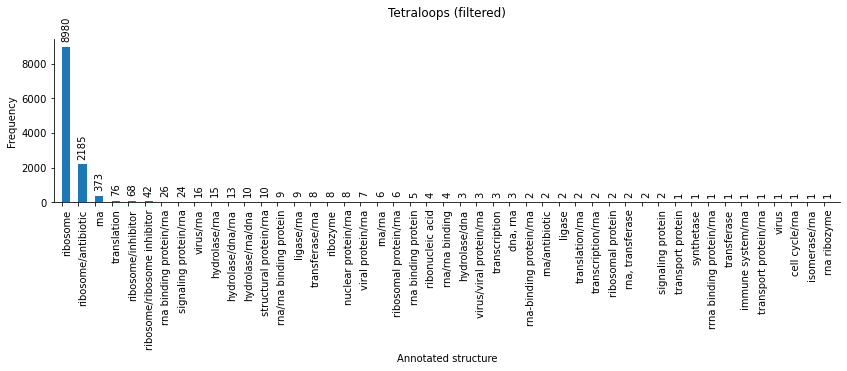

<Figure size 576x432 with 0 Axes>

In [78]:
plot_bar(get_counter_dict(tloops_filtered_structures), title="Tetraloops (filtered)", xlabel="Annotated structure", ylabel="Frequency", save=False)
plt.savefig(figures_dir/"annotated_structures.png")

# TODO make this work with series

# data = get_counter_dict(tloops_filtered_structures)

# bar_plot = plt.bar(range(len(data)), data.values(), align='edge', width=0.5)
# plt.bar_label(bar_plot, rotation='vertical', padding=5)
# plt.xticks(range(len(data)), data.keys(), rotation='vertical', horizontalalignment='left')
# plt.title("Annotated strucures", y=1.1)
# plt.xlabel("Annotated structure")
# plt.ylabel("Frequency")
    
# # Cosmetic adjustments
# plt.margins(x=0.5/len(data), tight=True)
# plt.spines[['right', 'top']].set_visible(False)


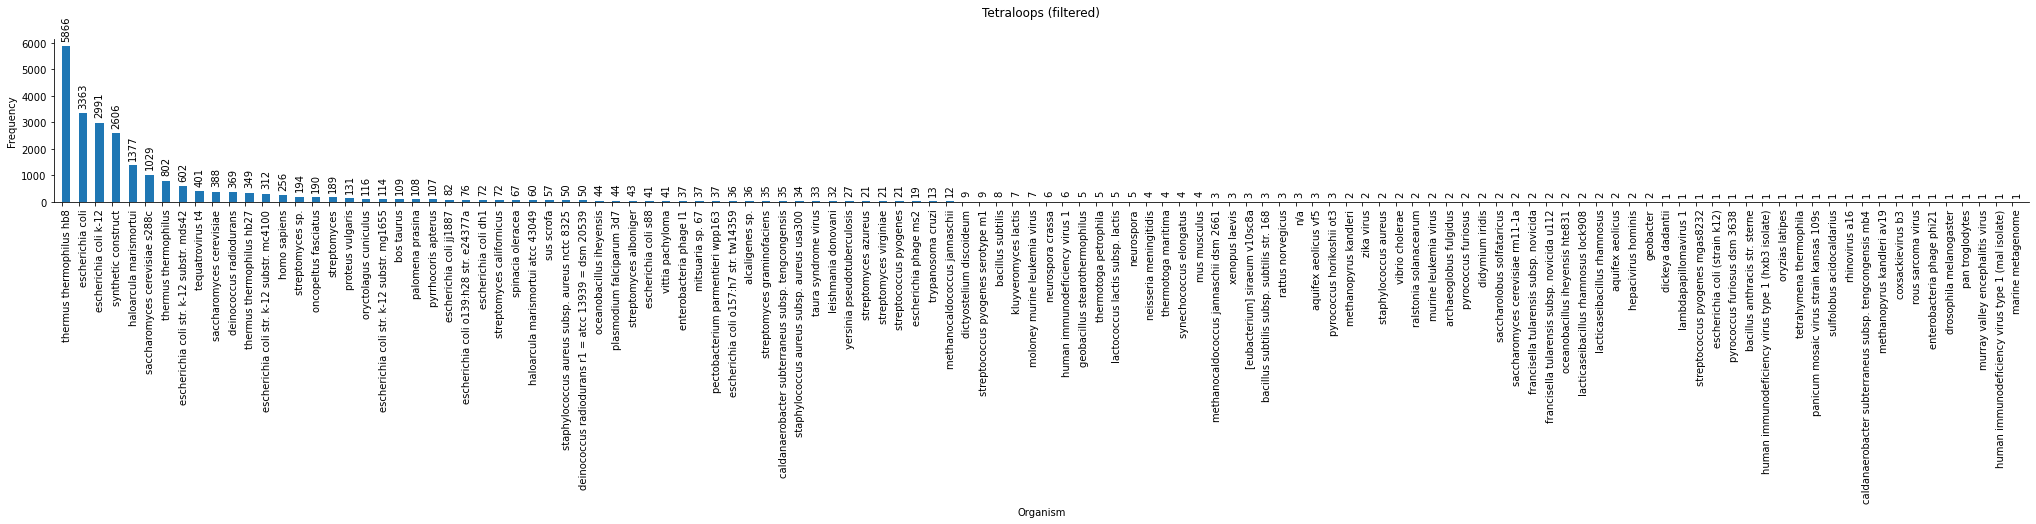

<Figure size 576x432 with 0 Axes>

In [79]:
organisms = [j.lower() for i in get_pdb_ids(tloops_filtered) for j in get_organisms(i)]
plot_bar(get_counter_dict(organisms), title="Tetraloops (filtered)", xlabel="Organism", ylabel="Frequency", save=False)
plt.savefig(figures_dir/"organisms.png")

# organisms = [j.lower() for i in get_pdb_ids(fragments_8_filtered, clusters=list(range(1,45))) for j in get_organisms(i)]
# plot_bar(get_counter_dict(organisms), title="Generated tetraloops", xlabel="Organism", ylabel="Frequency", save=False)

In [96]:
# Number of ribosomes

pdb_ids = get_pdb_ids(chains_annotated_filtered)
ribosomes = [i for i in pdb_ids if "ribosome" in get_structure(i).lower()]
print(f"{len(ribosomes)}/{len(pdb_ids)}")

520/836


In [98]:
# Chain length vs. structure annotation # TODO

lengths = [len(i) for i in chains_annotated_filtered]
structures = []

# Tetraloops
> The final tetraloop database is composed by 21,993 RNA fragments: 17,709 from X-ray, 3057 from NMR and 1227 from cryo-EM structures. The distributions of resolutions are shown in Fig. S1. [Bottaro et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5529312/)

According to Table SI1, there should be a total of 19383 tetraloops. I don't know where/what the remaining 2610 RNA fragments (from the total of 21993) are. The total number of "effective" tetraloops (members whose distance is above 0.07 eRMSD) is 16979.

In [26]:
# Cluster groups, as named in Bottaro et al. Table SI1

gnra = [1]
gnra_like = [1, 3, 6, 9, 25, 26, 36, 40]
uncg = [2]
uncg_like = [2, 5, 37, 44]
u_turn = [4]

Raw tetraloops:
- Amount: 19383
- Unique sequences: 292
- PDB IDs: 864


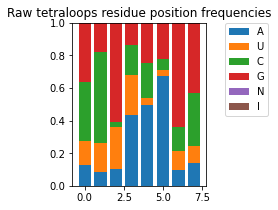

Figures saved to /figures

Filtered tetraloops:
- Amount: 11952
- Unique sequences: 292
- PDB IDs: 864


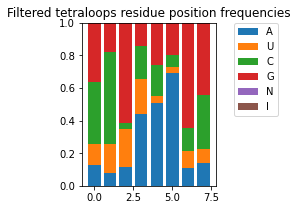

Figures saved to /figures

Generated tetraloops:
- Amount: 5032
- Unique sequences: 289
- PDB IDs: 469
- Chains: 572


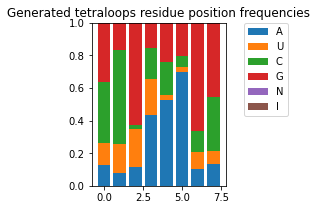

Figures saved to /figures



In [25]:
# Tetraloop statistics

stats(tloops_raw, 'Raw tetraloops', seqs_hist=True, clust_seqs_hist=True, clust_hist=True, res_pos_hist=True)
stats(tloops_filtered, 'Filtered tetraloops', seqs_hist=True, clust_seqs_hist=True, clust_hist=True, res_pos_hist=True)
tloop_fragments = [i for i in fragments_8_raw if i.clust_id != 0]
stats(tloop_fragments, 'Generated tetraloops', seqs_hist=True, clust_seqs_hist=True, clust_hist=True, res_pos_hist=True)

|           | Number of tetraloops | Unique sequences | PDB IDs                             |
|-----------|----------------------|------------------|-------------------------------------|
| Raw       | 19383                | 292              | 864                                 |
| Filtered  | 11952                | 292              | 864                                 |
| Generated | 5032*                | 289              | 471 (572 different Chains)          |

In [108]:
# Missing Tetraloop sequences (found in Bottaro but not in Generated)

tloop_raw_seqs = set([i.res_seq for i in tloops_raw])
tloop_fragment_seqs = set([i.res_seq for i in fragments_8_raw if i.clust_id != 0])
missing_seqs = tloop_raw_seqs - tloop_fragment_seqs
print(f"Sequences missing from Fragments: {missing_seqs}")
missing_tloops = [i for i in tloops_raw if i.res_seq in missing_seqs]
print(f"{len(missing_tloops)} tetraloops missing from Fragments:")
for i in missing_tloops: print(f"{i.clust_id:<3}{i.pdb_id:6}{i.res_seq:10}{i.res_nums[0]}")

Sequences missing from Fragments: {'AGGUGACU', 'AGGCGACU', 'GCGUAAGC'}
39 tetraloops missing from Fragments:
1  2gcs  AGGCGACU  112
1  2gcv  AGGCGACU  112
1  2h0s  AGGCGACU  112
1  2h0w  AGGCGACU  112
1  2h0x  AGGCGACU  112
1  2h0z  AGGCGACU  112
1  2ho6  AGGCGACU  112
1  2ho7  AGGCGACU  112
1  2nz4  AGGUGACU  107
1  2nz4  AGGUGACU  107
1  2nz4  AGGUGACU  107
1  2nz4  AGGUGACU  107
1  2z74  AGGCGACU  112
1  2z75  AGGCGACU  112
1  3b4a  AGGCGACU  112
1  3b4b  AGGCGACU  112
1  3b4c  AGGCGACU  112
1  3g8s  AGGUGACU  107
1  3g8s  AGGUGACU  107
1  3g8s  AGGUGACU  107
1  3g8s  AGGUGACU  107
1  3g8t  AGGUGACU  107
1  3g96  AGGUGACU  107
1  3g96  AGGUGACU  107
1  3g96  AGGUGACU  107
1  3g96  AGGUGACU  107
1  3g9c  AGGUGACU  107
1  3g9c  AGGUGACU  107
1  3g9c  AGGUGACU  107
1  3g9c  AGGUGACU  107
1  3l3c  AGGUGACU  107
1  3l3c  AGGUGACU  107
1  3l3c  AGGUGACU  107
1  3l3c  AGGUGACU  107
1  4meg  AGGCGACU  93
1  4meh  AGGCGACU  93
1  4r4p  GCGUAAGC  734
1  4r4v  GCGUAAGC  734
25 3g8t  AGGUGACU  

# Chains

In [104]:
stats(chains_annotated_raw, 'Raw annotated chains')
stats(chains_annotated_filtered, 'Filtered annotated chains')

Raw annotated chains:
- Amount: 3284
- Unique sequences: 1032
- PDB IDs: 864
- Chains: 3284
Figures saved to /figures

Filtered annotated chains:
- Amount: 836
- Unique sequences: 709
- PDB IDs: 533
- Chains: 836
Figures saved to /figures



|           | Number of chains | Unique sequences | PDB IDs                             |
|-----------|------------------|------------------|-------------------------------------|
| Raw       | 3284             | 1032             | 864                                 |
| Filtered  | 836              | 709              | 536                                 |
| Generated | 5032*            | 289              | 471 (572 different ReferenceChains) |

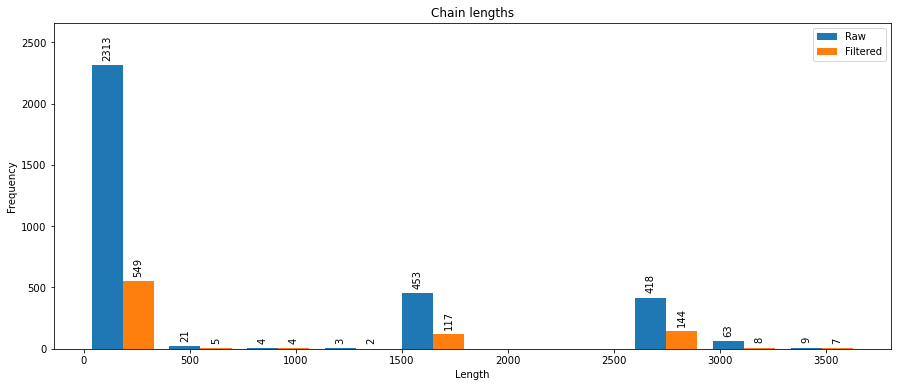

In [62]:
data = [[len(i) for i in chains_annotated_raw], [len(i) for i in chains_annotated_filtered]]

plt.figure(figsize=(15, 6))

values, _, bars = plt.hist(data, bins = 10, label=["Raw", "Filtered"])
plt.bar_label(bars[0], labels=[int(i) if i != 0 else "" for i in values[0]], rotation='vertical', padding=5)
plt.bar_label(bars[1], labels=[int(i) if i != 0 else "" for i in values[1]], rotation='vertical', padding=5)

plt.ylim([0, max(values[0])*1.15])

plt.title("Chain lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.legend()
plt.savefig(figures_dir/"chain_lengths.png")

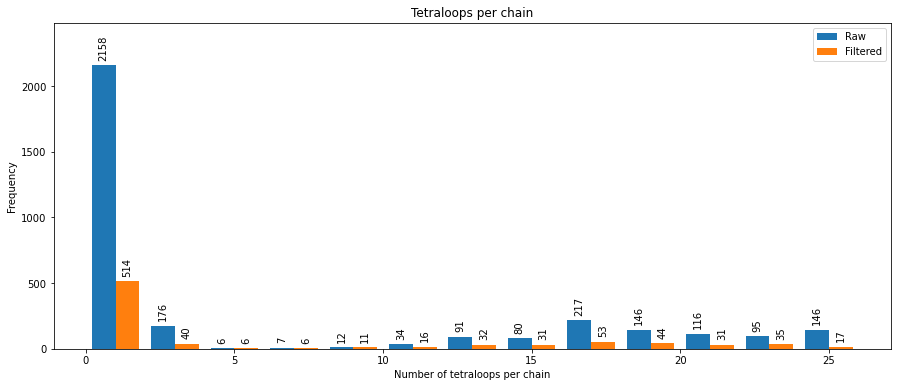

In [65]:
# Number of tetraloops per annotated chain
# why is the average number of tetraloops per PDB id so high (like 10 per pdb id)?
# check the chains with the highest number of tetraloops

data = [[len(i.tloops) for i in chains_annotated_raw], [len(i.tloops) for i in chains_annotated_filtered]]

plt.figure(figsize=(15, 6))

values, _, bars = plt.hist(data, bins=13, label=["Raw", "Filtered"]) #bins=np.arange(min(data[0]), max(data[0]) + 1, 1)
plt.bar_label(bars[0], labels=[int(i) if i != 0 else "" for i in values[0]], rotation='vertical', padding=5)
plt.bar_label(bars[1], labels=[int(i) if i != 0 else "" for i in values[1]], rotation='vertical', padding=5)

plt.ylim([0, max(values[0])*1.15])

plt.title("Tetraloops per chain")
plt.xlabel("Number of tetraloops per chain")
plt.ylabel("Frequency")
plt.legend()

plt.savefig(figures_dir/"tloops_per_chain.png")

# high_freq_chains = [i for i in chains_annotated_filtered if len(i.tloops) >= 10]
# high_freq_chains.sort(key=lambda x: len(x.tloops), reverse=True)
# print(f"{len(high_freq_chains)}/{len(chains_annotated_filtered)} filtered chains with >=10 tetraloops:")
# for i in high_freq_chains:
#     print(f"{i.pdb_id:6}{i.chain_id:4}{len(i.tloops):<4}")
#     for j in sorted(i.tloops, key=lambda x: x.res_nums[0]):
#         print(f"\t{j.clust_id:<4}{j.res_seq:10}{j.res_nums[0]}")

# Fragments

## Unique fragments
The number of unique RNA fragments is $4^{8} = 65536$ (or $6^{8} = 1679616$, if residues I and N are included). 

Expected number of tries to obtain $x$ unique sequences:
$$\sum\limits_{i=0}^x \frac{n}{n-i}$$
where $n$ = total number of unique sequences

The expected number of tries needed to obtain *all* unique fragments is $764646$.

In [132]:
pos_unique_frags = 4**8
print(f'Possible unique fragments: {pos_unique_frags}')

print(f'Total # of fragments: {len(fragments_8_raw)}')
unique_fragments = len(set([i.res_seq for i in fragments_8_filtered]))
print(f'Unique fragments: {unique_fragments}')

expected_tries = sum([pos_unique_frags/(pos_unique_frags-i) for i in range(unique_fragments)])
print(f'Expected # tries to obtain {unique_fragments} unique fragments: {round(expected_tries)}')

Possible unique fragments: 65536
Total # of fragments: 661843
Unique fragments: 36375
Expected # tries to obtain 36375 unique fragments: 53068


## Fragment of different lengths

In [133]:
tloops_8 = [i for i  in fragments_8_filtered if i.clust_id in gnra]
stats(tloops_8, 'Tetraloops 8', res_pos_hist=True)
tloops_10 = [i for i  in fragments_10_filtered if i.clust_id in gnra]
stats(tloops_10, 'Tetraloops 10', res_pos_hist=True)
tloops_12 = [i for i  in fragments_12_filtered if i.clust_id in gnra]
stats(tloops_12, 'Tetraloops 12', res_pos_hist=True)
tloops_14 = [i for i  in fragments_14_filtered if i.clust_id in gnra]
stats(tloops_14, 'Tetraloops 14', res_pos_hist=True)

Tetraloops 8:
- Amount: 2859
- Unique sequences: 150
- PDB IDs: 357
- Chains: 444
Figures saved to /figures

Tetraloops 10:
- Amount: 2859
- Unique sequences: 241
- PDB IDs: 357
- Chains: 444
Figures saved to /figures

Tetraloops 12:
- Amount: 2855
- Unique sequences: 298
- PDB IDs: 355
- Chains: 440
Figures saved to /figures

Tetraloops 14:
- Amount: 2849
- Unique sequences: 310
- PDB IDs: 349
- Chains: 434
Figures saved to /figures



In [135]:
print(len(set([i.res_seq for i in tloops_filtered if i.clust_id == 1])))

print(len(set([i.res_seq for i in fragments_14_filtered if i.clust_id == 1])))

[i.res_seq for i in tloops_filtered if i.clust_id == 1]

153
310


['GCGAAAGC',
 'UCGUGAGA',
 'GCUUCGGC',
 'CCGAGUGG',
 'CCGAAAGG',
 'GCGCGAGC',
 'CGGCAACG',
 'GCAGCCGC',
 'CCGGAAGG',
 'GCAGCCGC',
 'GCUCACGC',
 'GGGGAACC',
 'GGGCGACC',
 'CCGCAAGG',
 'GCGAAAGC',
 'GCAGCCGC',
 'UCGCAAGA',
 'GUGAAAGC',
 'GCGAAAGC',
 'GCGCGAGC',
 'ACGAAAGU',
 'GGGAAACC',
 'UCGCAAGA',
 'CCGCGAGG',
 'UGGAAACG',
 'GCGCGAGC',
 'GUGUGAAC',
 'ACGCGAGU',
 'AUGAAAGU',
 'ACGCGAGU',
 'CCGUGAGG',
 'CCGAAAGG',
 'CCGUGAGG',
 'CCGUAAGG',
 'CCGAACGG',
 'GGGAAACC',
 'GCGCGAGC',
 'GCGAAAGC',
 'UUGUGAAA',
 'UCGUGAGA',
 'GCGCGAGC',
 'CGGAAACG',
 'GCUAACGC',
 'GGGCGACC',
 'GAGAAAUC',
 'CCGCAAGG',
 'UCGUGAGA',
 'GCGCAAGC',
 'CCGAAAGG',
 'CAGCGAUG',
 'CCGCGAGG',
 'GUGAAAGC',
 'AUGAAAGU',
 'GAGUGAUU',
 'CCGGGAGG',
 'GCGAAGGC',
 'CCGUAAGG',
 'GGGAAACC',
 'GGGCGACC',
 'UGGAAACG',
 'AAGAAAUU',
 'CAGCGAUG',
 'GCAGCCGC',
 'GUGCAAGC',
 'UUGAAAAG',
 'GCGAAAGC',
 'GGGCGACC',
 'CCGUGAGG',
 'GCAGCCGC',
 'UCGUGAGA',
 'CGGCAACG',
 'GCGCAAGC',
 'CCGAAAGG',
 'GUGUGAAC',
 'UGGAAACG',
 'UUGAAGAG',
 'GGGAAACC',

## TODO

datasets
- tloops (raw and filtered)
- annotated chains (raw and filtered)

tloops from annotated chains
decoys from annotated chains

per cluster

table1

pdb

structure

organism